In [2]:
import pandas as pd
import numpy as np
import os

# -------------------------- 配置参数 --------------------------
INPUT_PATH = "D:\\workspace\\xiaoyao\\data\\widetable.parquet"
OUTPUT_PATH = "D:\\workspace\\xiaoyao\\data\\sw_all_levels_index_v2.parquet"

# 申万三级行业字段
SW_FIELDS = {
    "L1": "sw_l1_industry_name",
    "L2": "sw_l2_industry_name",
    "L3": "sw_l3_industry_name"
}


# -------------------------- 1. 读取数据并预处理 --------------------------
df = pd.read_parquet(
    INPUT_PATH,
    engine="pyarrow",
    columns=[
        "date", "stock_code",
        SW_FIELDS["L1"], SW_FIELDS["L2"], SW_FIELDS["L3"],
        "close", "pre_close", "circulating_market_cap"  # 新增流通市值用于加权
    ]
)

# 计算个股涨跌幅（%）
df["pct_change"] = (df["close"] / df["pre_close"] - 1) * 100
df["date"] = pd.to_datetime(df["date"])

# 过滤无效数据
df = df.dropna(subset=["pct_change", "circulating_market_cap"] + list(SW_FIELDS.values()))
df = df[(df["pct_change"].abs() <= 20) & (df["circulating_market_cap"] > 0)]


# -------------------------- 2. 核心：平方根加权计算行业指数 --------------------------
all_index = []

for level in ["L1", "L2", "L3"]:
    industry_col = SW_FIELDS[level]
    print(f"计算{level}级行业指数（平方根加权）...")
    
    # 按日期+行业分组处理
    grouped = df.groupby(["date", industry_col])
    index_data = []
    
    for (date, industry), group in grouped:
        n_stocks = len(group)
        # 过滤成分股数量（L3≥3，L2/L1≥5）
        if (level == "L3" and n_stocks < 3) or (level != "L3" and n_stocks < 5):
            continue
        
        # 计算平方根权重：权重=√(流通市值)/Σ√(流通市值)
        group["sqrt_cap"] = np.sqrt(group["circulating_market_cap"])  # 流通市值开平方
        total_sqrt_cap = group["sqrt_cap"].sum()
        group["weight"] = group["sqrt_cap"] / total_sqrt_cap
        
        # 加权计算行业涨跌幅（保留信息，控差距）
        index_pct = (group["pct_change"] * group["weight"]).sum()
        
        # 记录权重分布（监控差距：最大权重占比）
        max_weight_ratio = group["weight"].max() * 100  # 最大权重个股占比（%）
        
        index_data.append({
            "trade_date": date,
            "level": level,
            "industry_name": industry,
            "index_pct_change": round(index_pct, 2),  # 平方根加权涨跌幅
            "component_count": n_stocks,
            "max_weight_ratio": round(max_weight_ratio, 1)  # 最大权重占比（监控是否差距过大）
        })
    
    # 转换为DataFrame并添加到结果
    level_df = pd.DataFrame(index_data)
    all_index.append(level_df)


# -------------------------- 3. 标准化处理（跨层级可比） --------------------------
index_df = pd.concat(all_index, ignore_index=True)

# 按层级标准化涨跌幅（Z-score）
def normalize(group):
    mean = group["index_pct_change"].mean()
    std = group["index_pct_change"].std()
    group["std_pct"] = (group["index_pct_change"] - mean) / (std if std != 0 else 1)
    return group

index_df = index_df.groupby("level", group_keys=False).apply(normalize)
index_df["std_pct"] = index_df["std_pct"].round(4)


# -------------------------- 4. 过滤极端权重行业（确保公平性） --------------------------
# 剔除最大权重占比超过50%的行业（避免单只股票主导）
index_df = index_df[index_df["max_weight_ratio"] <= 50]


# -------------------------- 5. 保存结果 --------------------------
os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)
index_df.to_parquet(OUTPUT_PATH, engine="pyarrow", index=False, compression="snappy")

# 输出信息
print("\n" + "="*60)
print("✅ 带信息权重的三级行业指数生成完成！")
print(f"文件路径：{OUTPUT_PATH}")
print(f"各层级行业数量：")
for level in ["L1", "L2", "L3"]:
    cnt = index_df[index_df["level"] == level]["industry_name"].nunique()
    print(f"- {level}级：{cnt} 个行业（已过滤极端权重）")
print("核心字段新增：max_weight_ratio（行业内最大权重占比%，监控差距）")
print("="*60)

计算L1级行业指数（平方根加权）...
计算L2级行业指数（平方根加权）...
计算L3级行业指数（平方根加权）...


C:\Users\user\AppData\Local\Temp\ipykernel_19012\3507742976.py:89: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  index_df = index_df.groupby("level", group_keys=False).apply(normalize)



✅ 带信息权重的三级行业指数生成完成！
文件路径：D:\workspace\xiaoyao\data\sw_all_levels_index_v2.parquet
各层级行业数量：
- L1级：31 个行业（已过滤极端权重）
- L2级：124 个行业（已过滤极端权重）
- L3级：305 个行业（已过滤极端权重）
核心字段新增：max_weight_ratio（行业内最大权重占比%，监控差距）


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta

# -------------------------- 配置参数 --------------------------
# 输入：已生成的三级行业指数文件
INDEX_PATH = "D:\\workspace\\xiaoyao\\data\\sw_all_levels_index_v2.parquet"
# 输出：图表保存路径
CHART_SAVE_PATH = ".\\charts"
os.makedirs(CHART_SAVE_PATH, exist_ok=True)

# 绘图样式配置（美观+专业）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False  # 支持负号
plt.rcParams['figure.figsize'] = (12, 8)  # 图表尺寸
plt.rcParams['font.size'] = 10  # 基础字体大小


# -------------------------- 1. 数据加载与预处理 --------------------------
def load_industry_data():
    """加载行业指数数据并预处理"""
    df = pd.read_parquet(INDEX_PATH)
    # 按日期排序
    df = df.sort_values(["level", "industry_name", "trade_date"]).reset_index(drop=True)
    # 计算近3日/5日累计涨跌幅（用于热点识别）
    df["cum_pct_3d"] = df.groupby(["level", "industry_name"])["index_pct_change"].rolling(3).sum().reset_index(level=[0,1], drop=True)
    df["cum_pct_5d"] = df.groupby(["level", "industry_name"])["index_pct_change"].rolling(5).sum().reset_index(level=[0,1], drop=True)
    # 标记“连续上涨”（近5日每日涨跌幅均为正）
    df["is_continuous_up"] = df.groupby(["level", "industry_name"])["index_pct_change"].rolling(5).apply(
        lambda x: (x > 0).all()
    ).reset_index(level=[0,1], drop=True).fillna(0).astype(int)
    return df

df = load_industry_data()
latest_date = df["trade_date"].max()  # 最新交易日
print(f"✅ 数据加载完成，覆盖日期：{df['trade_date'].min().strftime('%Y-%m-%d')} 至 {latest_date.strftime('%Y-%m-%d')}")


# -------------------------- 2. 绘制行业走势图（3类核心图表） --------------------------
def plot_single_industry_trend(industry_name, level="L2", lookback_days=60):
    """
    绘制单行业历史趋势图（折线图）
    :param industry_name: 行业名称（如“电机II”）
    :param level: 行业层级（L1/L2/L3）
    :param lookback_days: 回溯天数（默认60天）
    """
    # 筛选行业数据
    industry_data = df[(df["industry_name"] == industry_name) & (df["level"] == level)].copy()
    if len(industry_data) == 0:
        print(f"❌ 未找到{level}级行业：{industry_name}")
        return
    
    # 筛选回溯周期数据
    start_date = latest_date - timedelta(days=lookback_days)
    industry_data = industry_data[industry_data["trade_date"] >= start_date]
    if len(industry_data) < 10:
        print(f"⚠️  {industry_name} 近{lookback_days}天数据不足，自动调整为全部数据")
        start_date = industry_data["trade_date"].min()
    
    # 创建图表
    fig, ax = plt.subplots(1, 1)
    
    # 绘制行业涨跌幅趋势（主折线）
    ax.plot(
        industry_data["trade_date"], 
        industry_data["index_pct_change"], 
        color="#1f77b4", 
        linewidth=2, 
        label=f"{industry_name} 单日涨跌幅"
    )
    
    # 叠加5日移动平均线（平滑趋势）
    industry_data["ma5_pct"] = industry_data["index_pct_change"].rolling(5).mean()
    ax.plot(
        industry_data["trade_date"], 
        industry_data["ma5_pct"], 
        color="#ff7f0e", 
        linewidth=1.5, 
        linestyle="--", 
        label="5日移动平均"
    )
    
    # 标记连续上涨区间（填充绿色）
    up_periods = industry_data[industry_data["is_continuous_up"] == 1]
    if len(up_periods) > 0:
        ax.scatter(
            up_periods["trade_date"], 
            up_periods["index_pct_change"], 
            color="#2ca02c", 
            s=30, 
            marker="^", 
            label="连续上涨日"
        )
    
    # 图表美化
    ax.set_title(f"{level}级行业：{industry_name} 近{lookback_days}天涨跌幅趋势", fontsize=14, fontweight="bold")
    ax.set_xlabel("日期", fontsize=12)
    ax.set_ylabel("涨跌幅（%）", fontsize=12)
    ax.axhline(y=0, color="black", linewidth=0.8, linestyle=":")  # 0轴参考线
    ax.legend(loc="best", fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # 保存图表
    save_name = f"{level}_{industry_name}_{lookback_days}d_trend.png"
    save_path = os.path.join(CHART_SAVE_PATH, save_name)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ 单行业趋势图已保存：{save_path}")


def plot_multi_industry_compare(level="L1", top_n=5, lookback_days=30):
    """
    绘制多行业对比图（柱状图）
    :param level: 行业层级（默认L1，大类对比）
    :param top_n: 对比行业数量（默认TOP5）
    :param lookback_days: 回溯天数（默认30天）
    """
    # 筛选近30天数据，计算各行业累计涨跌幅
    start_date = latest_date - timedelta(days=lookback_days)
    level_data = df[(df["trade_date"] >= start_date) & (df["level"] == level)].copy()
    
    # 计算各行业近30天累计涨跌幅（取最新值）
    industry_cum_pct = level_data.groupby("industry_name")["cum_pct_5d"].last().sort_values(ascending=False).head(top_n)
    
    # 创建图表
    fig, ax = plt.subplots(1, 1)
    
    # 绘制柱状图（颜色区分强弱）
    colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, top_n))  # 红→黄→绿（强→弱）
    bars = ax.bar(
        range(len(industry_cum_pct)), 
        industry_cum_pct.values, 
        color=colors, 
        alpha=0.8, 
        edgecolor="black", 
        linewidth=0.5
    )
    
    # 在柱子上添加数值标签
    for i, (bar, pct) in enumerate(zip(bars, industry_cum_pct.values)):
        ax.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height() + (0.5 if pct > 0 else -1.5), 
            f"{pct:.1f}%", 
            ha="center", 
            va="bottom" if pct > 0 else "top", 
            fontsize=10, 
            fontweight="bold"
        )
    
    # 图表美化
    ax.set_title(f"{level}级行业近{lookback_days}天累计涨跌幅TOP{top_n}对比", fontsize=14, fontweight="bold")
    ax.set_xlabel("行业名称", fontsize=12)
    ax.set_ylabel("近5日累计涨跌幅（%）", fontsize=12)
    ax.set_xticks(range(len(industry_cum_pct)))
    ax.set_xticklabels(industry_cum_pct.index, rotation=45, ha="right")
    ax.axhline(y=0, color="black", linewidth=0.8, linestyle=":")
    ax.grid(True, alpha=0.3, axis="y")
    
    # 保存图表
    save_name = f"{level}_top{top_n}_{lookback_days}d_compare.png"
    save_path = os.path.join(CHART_SAVE_PATH, save_name)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ 多行业对比图已保存：{save_path}")


def plot_industry_heatmap(level="L2", lookback_days=10):
    """
    绘制行业热度热力图（看全层级活跃度）
    :param level: 行业层级（默认L2，中类行业）
    :param lookback_days: 回溯天数（默认10天）
    """
    # 筛选数据并 pivot 为热力图格式
    start_date = latest_date - timedelta(days=lookback_days)
    heatmap_data = df[(df["trade_date"] >= start_date) & (df["level"] == level)].copy()
    
    # 取TOP10行业（按近10天累计涨跌幅）
    top_industries = heatmap_data.groupby("industry_name")["cum_pct_5d"].last().sort_values(ascending=False).head(20).index
    heatmap_data = heatmap_data[heatmap_data["industry_name"].isin(top_industries)]
    
    # 转换为透视表（行：行业，列：日期，值：标准化涨跌幅）
    pivot_data = heatmap_data.pivot_table(
        index="industry_name",
        columns="trade_date",
        values="std_pct",
        fill_value=0
    )
    
    # 创建图表
    fig, ax = plt.subplots(1, 1)
    
    # 绘制热力图
    im = ax.imshow(pivot_data.values, cmap="RdYlGn", aspect="auto", vmin=-2, vmax=2)  # 标准化范围：-2（弱）→2（强）
    
    # 设置坐标轴标签
    ax.set_xticks(range(len(pivot_data.columns)))
    ax.set_xticklabels([d.strftime("%m-%d") for d in pivot_data.columns], rotation=45, ha="right")
    ax.set_yticks(range(len(pivot_data.index)))
    ax.set_yticklabels(pivot_data.index)
    
    # 添加数值标签（仅显示绝对值>0.5的，避免杂乱）
    for i in range(len(pivot_data.index)):
        for j in range(len(pivot_data.columns)):
            val = pivot_data.iloc[i, j]
            if abs(val) > 0.5:
                ax.text(
                    j, i, 
                    f"{val:.1f}", 
                    ha="center", 
                    va="center", 
                    color="white" if abs(val) > 1 else "black", 
                    fontsize=8
                )
    
    # 图表美化
    ax.set_title(f"{level}级行业近{lookback_days}天热度热力图（标准化涨跌幅）", fontsize=14, fontweight="bold")
    ax.set_xlabel("日期", fontsize=12)
    ax.set_ylabel("行业名称", fontsize=12)
    
    # 添加颜色条（解释热度）
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("标准化涨跌幅（越强越红，越弱越绿）", fontsize=10)
    
    # 保存图表
    save_name = f"{level}_{lookback_days}d_heatmap.png"
    save_path = os.path.join(CHART_SAVE_PATH, save_name)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"✅ 行业热力图已保存：{save_path}")


# -------------------------- 3. 热点行业识别（输出清单） --------------------------
def identify_hot_industries():
    """识别热点行业，输出3类清单：短期热点、趋势热点、层级共振热点"""
    print("\n" + "="*80)
    print(f"📅 {latest_date.strftime('%Y-%m-%d')} 申万三级行业热点清单")
    print("="*80)
    
    # 1. 短期热点（近3日标准化涨跌幅TOP5，各层级）
    print("\n【1. 短期热点行业（近3日标准化涨跌幅TOP5）】")
    for level in ["L1", "L2", "L3"]:
        level_data = df[(df["trade_date"] == latest_date) & (df["level"] == level)].copy()
        top5 = level_data.sort_values("std_pct", ascending=False).head(5)[
            ["industry_name", "index_pct_change", "std_pct", "component_count"]
        ]
        print(f"\n{level}级：")
        print(top5.to_string(index=False))
    
    # 2. 趋势热点（近5日连续上涨+近3日累计涨超5%）
    print("\n【2. 趋势热点行业（近5日连续上涨+近3日累计涨超5%）】")
    trend_hot = df[
        (df["trade_date"] == latest_date) & 
        (df["is_continuous_up"] == 1) & 
        (df["cum_pct_3d"] >= 5)
    ][["level", "industry_name", "cum_pct_3d", "cum_pct_5d"]].sort_values("cum_pct_5d", ascending=False)
    if len(trend_hot) == 0:
        print("⚠️  暂无符合条件的趋势热点行业")
    else:
        print(trend_hot.to_string(index=False))
    
    # 3. 层级共振热点（L1/L2/L3同领域行业均上榜）
    print("\n【3. 层级共振热点行业（全链条走强）】")
    # 提取各层级TOP3行业关键词（如“电机”“新能源”）
    l1_top = set(df[(df["trade_date"] == latest_date) & (df["level"] == "L1")].sort_values("std_pct", ascending=False).head(3)["industry_name"])
    l2_top = set(df[(df["trade_date"] == latest_date) & (df["level"] == "L2")].sort_values("std_pct", ascending=False).head(5)["industry_name"])
    l3_top = set(df[(df["trade_date"] == latest_date) & (df["level"] == "L3")].sort_values("std_pct", ascending=False).head(10)["industry_name"])
    
    # 识别共振领域（如“新能源”相关）
    resonance_themes = []
    # 示例：新能源相关关键词
    new_energy_keywords = ["新能源", "电气设备", "光伏", "储能", "电池"]
    for keyword in new_energy_keywords:
        l1_match = any(keyword in name for name in l1_top)
        l2_match = any(keyword in name for name in l2_top)
        l3_match = any(keyword in name for name in l3_top)
        if l1_match and l2_match and l3_match:
            resonance_themes.append(keyword)
    
    if resonance_themes:
        for theme in resonance_themes:
            print(f"\n领域：{theme}")
            print(f"- L1级：{[name for name in l1_top if theme in name][0]}")
            print(f"- L2级：{[name for name in l2_top if theme in name][0]}")
            print(f"- L3级：{[name for name in l3_top if theme in name][0]}")
    else:
        print("⚠️  暂无层级共振的热点领域")
    
    print("\n" + "="*80)


# -------------------------- 4. 主函数（一键运行绘图+热点识别） --------------------------
def main():
    # 1. 绘制核心图表（可根据需求调整参数）
    print("="*60)
    print("开始绘制行业走势图...")
    print("="*60)
    # 示例1：绘制L2级“电机II”近60天趋势图
    plot_single_industry_trend(industry_name="证券III", level="L3", lookback_days=60)
    # 示例2：绘制L1级TOP5行业近30天对比图
    plot_multi_industry_compare(level="L3", top_n=20, lookback_days=60)
    # 示例3：绘制L2级行业近10天热力图
    plot_industry_heatmap(level="L3", lookback_days=30)
    
    # 2. 识别热点行业
    identify_hot_industries()
    
    print(f"\n✅ 全部完成！图表保存路径：{CHART_SAVE_PATH}")


if __name__ == "__main__":
    main()

✅ 数据加载完成，覆盖日期：2025-01-02 至 2025-10-30
开始绘制行业走势图...
✅ 单行业趋势图已保存：.\charts\L3_证券III_60d_trend.png
✅ 多行业对比图已保存：.\charts\L3_top20_60d_compare.png
✅ 行业热力图已保存：.\charts\L3_30d_heatmap.png

📅 2025-10-30 申万三级行业热点清单

【1. 短期热点行业（近3日标准化涨跌幅TOP5）】

L1级：
industry_name  index_pct_change  std_pct  component_count
          钢铁I              1.40   0.8644               44
        有色金属I              0.47   0.2278              137
          银行I              0.04  -0.0666               42
        交通运输I              0.02  -0.0803              126
        公用事业I             -0.17  -0.2103              131

L2级：
industry_name  index_pct_change  std_pct  component_count
       能源金属II              3.71   2.1481               13
       冶钢原料II              2.06   1.1556                9
         普钢II              1.28   0.6864               23
         特钢II              1.16   0.6142               12
       航运港口II              0.88   0.4458               34

L3级：
industry_name  index_pct_change  std_pct  component_c

分析时间范围: 2025-10-20 至 2025-10-30
已计算 9 天的热门行业TOP10

【2025-10-29 vs 2025-10-30】TOP10行业变动对比
行业名称                 | 前日排名     | 当日排名     | 涨跌幅(%)     | 变动类型
----------------------------------------------------------------------------------------------------
能源金属II               | 1.0      | 1.0      | 2.15       | 不变
普钢II                 | -        | 2.0      | 0.69       | 新增
航运港口II               | -        | 3.0      | 0.45       | 新增
特钢II                 | -        | 4.0      | 0.61       | 新增
商用车II                | -        | 5.0      | 0.43       | 新增
稀有金属II               | 3.0      | 6.0      | 0.18       | 下降
风电设备II               | -        | 7.0      | 0.05       | 新增
金属非金属新材料II           | -        | 8.0      | -0.04      | 新增
城商行II                | -        | 9.0      | 0.04       | 新晋
医药商业II               | -        | 10.0     | -0.05      | 新增
光伏设备II               | 2.0      | -        | -          | 剔除
玻璃制造II               | 4.0      | -        | -          | 剔除
工业金属II         

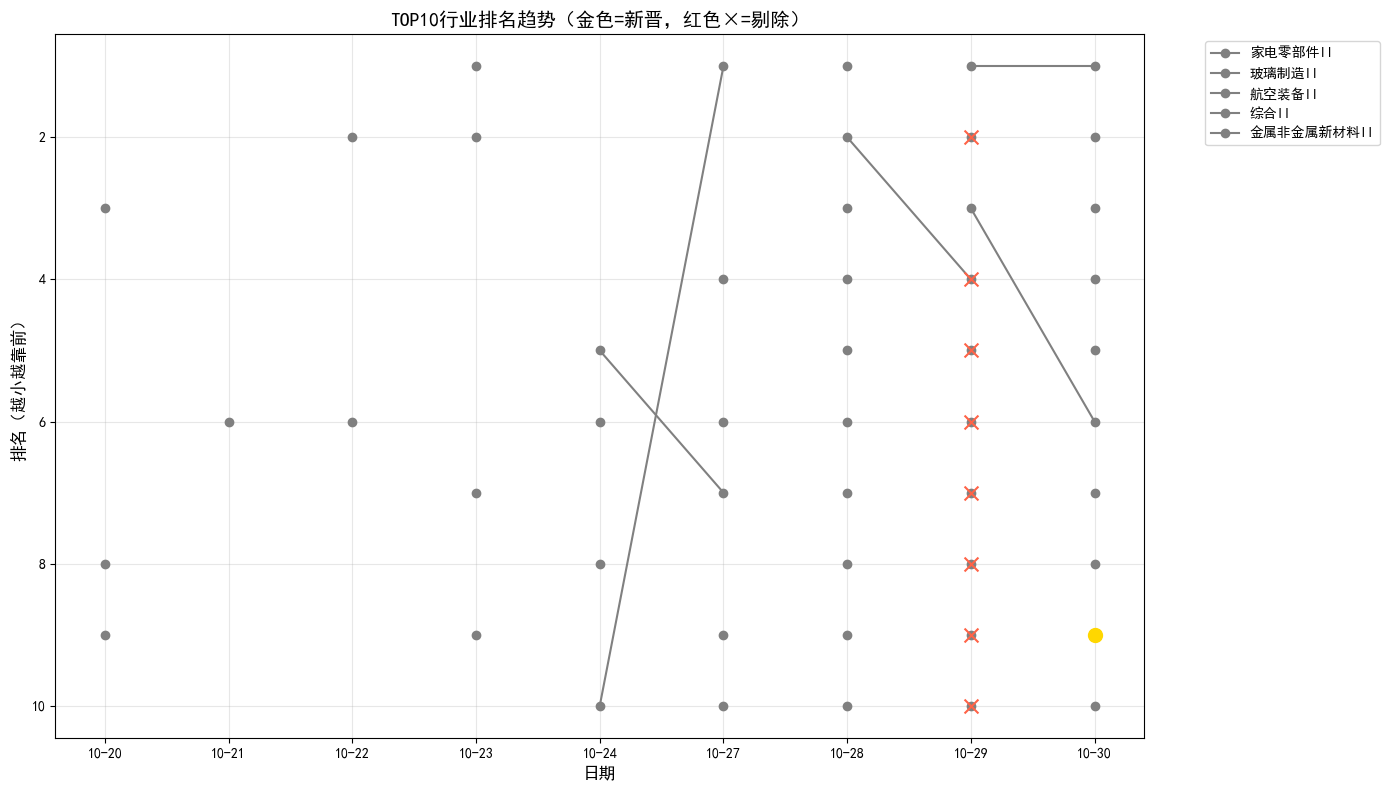

: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# -------------------------- 配置参数 --------------------------
INDEX_PATH = "D:\\workspace\\xiaoyao\\data\\sw_all_levels_index_v2.parquet"
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False

# 时间范围（最近10天）
END_DATE = pd.to_datetime(datetime.now().date())
START_DATE = END_DATE - timedelta(days=10)

# 颜色定义（用于标记变动类型）
COLOR_NEW = '#32CD32'    # 新增行业：绿色
COLOR_REMOVE = '#FF6347' # 剔除行业：红色
COLOR_FIRST = '#FFD700'  # 新晋行业：金色
COLOR_UP = '#20B2AA'     # 排名上升：青色
COLOR_DOWN = '#FFA500'   # 排名下降：橙色


# -------------------------- 1. 数据加载与TOP10计算 --------------------------
def load_and_calculate():
    # 读取数据
    index_df = pd.read_parquet(INDEX_PATH)
    index_df = index_df[
        (index_df["level"] == "L2") &
        (index_df["trade_date"] >= START_DATE) &
        (index_df["trade_date"] <= END_DATE)
    ].copy()
    
    # 检查必要字段
    required_cols = ["trade_date", "industry_name", "std_pct", "component_count", "max_weight_ratio"]
    missing_cols = set(required_cols) - set(index_df.columns)
    if missing_cols:
        raise ValueError(f"缺少必要字段：{missing_cols}")
    
    # 计算每日TOP10
    daily_top10 = {}
    for date in sorted(index_df["trade_date"].unique()):
        daily_data = index_df[index_df["trade_date"] == date].copy()
        
        # 得分计算
        std_min, std_max = daily_data["std_pct"].min(), daily_data["std_pct"].max()
        daily_data["heat_score"] = ((daily_data["std_pct"] - std_min)/(std_max - std_min + 1e-8)) * 50
        daily_data["count_score"] = np.where(
            (daily_data["component_count"]>=10)&(daily_data["component_count"]<=50),20,
            np.where((daily_data["component_count"]<5)|(daily_data["component_count"]>100),5,10)
        )
        daily_data["diversity_score"] = (1 - daily_data["max_weight_ratio"]/100) * 30
        daily_data["total_score"] = (daily_data["heat_score"] + daily_data["count_score"] + daily_data["diversity_score"]).round(1)
        
        # 取TOP10
        top10 = daily_data.sort_values("total_score", ascending=False).head(10)[
            ["industry_name", "std_pct", "total_score"]
        ].reset_index(drop=True)
        top10["排名"] = range(1, 11)
        daily_top10[date] = top10
    
    return daily_top10


# -------------------------- 2. 直观化对比表格（修复索引错误） --------------------------
def generate_comparison_table(daily_top10):
    """生成前后日对比表格，用颜色标记变动类型（修复set作为索引的错误）"""
    all_dates = sorted(daily_top10.keys())
    if len(all_dates) < 2:
        return None, None, None
    
    # 取最后两天数据对比
    prev_date = all_dates[-2]
    curr_date = all_dates[-1]
    prev_df = daily_top10[prev_date].set_index("industry_name")
    curr_df = daily_top10[curr_date].set_index("industry_name")
    
    # 修复：用列表而非set创建索引（确保唯一性和有序性）
    all_industries = list(set(prev_df.index.tolist() + curr_df.index.tolist()))
    comparison = pd.DataFrame(index=all_industries)  # 用列表作为索引
    
    # 填充数据
    comparison["前日排名"] = prev_df["排名"].reindex(comparison.index)
    comparison["当日排名"] = curr_df["排名"].reindex(comparison.index)
    comparison["涨跌幅(%)"] = curr_df["std_pct"].reindex(comparison.index).round(2)
    
    # 标记变动类型
    def mark_change(row):
        if pd.isna(row["前日排名"]) and not pd.isna(row["当日排名"]):
            # 检查是否为历史首次出现
            is_first = True
            for d in daily_top10:
                if d == curr_date:
                    continue
                if row.name in daily_top10[d]["industry_name"].values:
                    is_first = False
                    break
            return "新晋" if is_first else "新增"
        elif not pd.isna(row["前日排名"]) and pd.isna(row["当日排名"]):
            return "剔除"
        elif not pd.isna(row["前日排名"]) and not pd.isna(row["当日排名"]):
            if row["当日排名"] < row["前日排名"]:
                return "上升"
            elif row["当日排名"] > row["前日排名"]:
                return "下降"
            else:
                return "不变"
        else:
            return "-"
    
    comparison["变动类型"] = comparison.apply(mark_change, axis=1)
    # 排序：先按当日排名，再按前日排名
    comparison = comparison.sort_values(
        by=["当日排名", "前日排名"], 
        na_position="last"
    ).fillna("-")
    
    return comparison, prev_date, curr_date


# -------------------------- 3. 变动趋势可视化 --------------------------
def plot_trend_chart(daily_top10):
    """绘制TOP10行业趋势图，用颜色区分新增/剔除"""
    all_dates = sorted(daily_top10.keys())
    if len(all_dates) < 3:
        print("数据不足3天，无法绘制趋势图")
        return
    
    # 提取所有出现过的行业及排名
    rank_data = {}
    for date in all_dates:
        for _, row in daily_top10[date].iterrows():
            ind = row["industry_name"]
            if ind not in rank_data:
                rank_data[ind] = {d: np.nan for d in all_dates}
            rank_data[ind][date] = row["排名"]
    
    # 转换为DataFrame（行业×日期，值为排名）
    rank_df = pd.DataFrame(rank_data).T
    
    # 筛选最近3天有变动的行业（前15名）
    recent_inds = set()
    for d in all_dates[-3:]:
        recent_inds.update(daily_top10[d]["industry_name"].head(15))
    rank_df = rank_df.loc[list(recent_inds)]  # 修复：set转为list
    
    # 绘图
    plt.figure(figsize=(14, 8))
    date_labels = [d.strftime("%m-%d") for d in all_dates]
    
    for i, ind in enumerate(rank_df.index):
        ranks = rank_df.loc[ind].values
        # 标记首次出现的日期（新晋）
        first_date_idx = np.where(~pd.isna(ranks))[0][0] if any(~pd.isna(ranks)) else -1
        
        # 绘制线条
        plt.plot(
            date_labels, ranks, 
            marker='o', markersize=6, 
            label=ind if i < 5 else "",  # 只显示前5个标签避免杂乱
            color=COLOR_FIRST if first_date_idx == len(all_dates)-1 else 'gray'
        )
        
        # 标注新增/剔除
        if first_date_idx == len(all_dates)-1:  # 当日新晋
            plt.scatter(date_labels[-1], ranks[-1], color=COLOR_FIRST, s=100, zorder=5)
        if len(ranks)>=2 and not pd.isna(ranks[-2]) and pd.isna(ranks[-1]):  # 当日剔除
            plt.scatter(date_labels[-2], ranks[-2], color=COLOR_REMOVE, s=100, zorder=5, marker='x')
    
    plt.gca().invert_yaxis()  # 排名1在最上方
    plt.title("TOP10行业排名趋势（金色=新晋，红色×=剔除）", fontsize=14)
    plt.xlabel("日期", fontsize=12)
    plt.ylabel("排名（越小越靠前）", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# -------------------------- 4. 彩色打印表格 --------------------------
def print_colored_table(comparison, prev_date, curr_date):
    """用彩色文字打印对比表格"""
    if comparison is None:
        return
    
    print(f"\n" + "="*100)
    print(f"【{prev_date.strftime('%Y-%m-%d')} vs {curr_date.strftime('%Y-%m-%d')}】TOP10行业变动对比")
    print("="*100)
    print(f"{'行业名称':<20} | {'前日排名':<8} | {'当日排名':<8} | {'涨跌幅(%)':<10} | 变动类型")
    print("-"*100)
    
    for ind, row in comparison.iterrows():
        # 根据变动类型设置颜色
        if row["变动类型"] == "新晋":
            color_code = f"\033[93m"  # 金色
        elif row["变动类型"] == "新增":
            color_code = f"\033[92m"  # 绿色
        elif row["变动类型"] == "剔除":
            color_code = f"\033[91m"  # 红色
        elif row["变动类型"] == "上升":
            color_code = f"\033[96m"  # 青色
        elif row["变动类型"] == "下降":
            color_code = f"\033[91m"  # 红色
        else:
            color_code = f"\033[0m"   # 默认
        
        # 打印行（带颜色）
        print(f"{color_code}{ind:<20} | {row['前日排名']:<8} | {row['当日排名']:<8} | {row['涨跌幅(%)']:<10} | {row['变动类型']}\033[0m")


# -------------------------- 5. 主函数 --------------------------
def main():
    print(f"分析时间范围: {START_DATE.strftime('%Y-%m-%d')} 至 {END_DATE.strftime('%Y-%m-%d')}")
    
    try:
        # 1. 计算每日TOP10
        daily_top10 = load_and_calculate()
        print(f"已计算 {len(daily_top10)} 天的热门行业TOP10")
        
        # 2. 生成对比表格并彩色打印
        comparison, prev_date, curr_date = generate_comparison_table(daily_top10)
        print_colored_table(comparison, prev_date, curr_date)
        
        # 3. 绘制趋势图
        plot_trend_chart(daily_top10)
    
    except Exception as e:
        print(f"执行出错: {str(e)}")


if __name__ == "__main__":
    main()